# The purpose of this notebook

This is the final notebook that makes figures for the paper.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
n_boot = 500

In [4]:
from IPython.display import display, HTML

import string

import numpy as np
np.set_printoptions(precision=3)

import pandas as pd
pd.set_option('display.max_rows', 500)

import scipy.stats as st
import statsmodels.stats.multitest as mt

import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

import suppression as s
import utils

In [5]:
pd.__version__

'1.2.3'

In [6]:
sns.__version__

'0.11.1'

In [7]:
gaba_fn = 'gaba_data_2019.txt'
supp_fn = 'supp_data_individual_20170427.txt'

In [8]:
sdf = utils.load_psychophys(supp_fn)
gaba_col = 'mean_occ_all' #'motor' # or 'occ_binoc', 'mean_occ_all', 'motor'
gdf = utils.load_gaba(gaba_fn, gaba_col)
sdf.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2


In [9]:
def categorize(df, col, values=None):
    df[col] = df[col].astype("category")
    if values is not None:
        if len(values)==len(df[col].cat.categories):
            df[col].cat.rename_categories(values, inplace=True)
            df[col].cat.reorder_categories(values.values(), inplace=True)
    return df

pop_dict = {'Amblyope':'PWA', 'Control':'NSP'}

gdf = categorize(gdf, 'Population', pop_dict)
sdf = categorize(sdf, 'Population', pop_dict)

In [10]:
gdf.Population.cat.categories

Index(['PWA', 'NSP'], dtype='object')

In [11]:
demos = pd.read_csv('demos.csv', lineterminator="\r")
# 1 = amb, 0 = control
subs_to_swap_eyes = demos[demos.swapNDE_EY==1].initials.unique() # subjects whose NDE/DE assignment is wrong in sdf
print(subs_to_swap_eyes)
demos

['ai' 'ct' 'dl' 'ei' 'kw' 'nl']


,numID,initials,scanID,age,sex,labelSex,group,labelGroup,sexGroupNum,ambType,...,hasSS,nde,labelNDE,originNDE,swapNDE_EY,acuityDE,acuityNDE,iadLogMAR,occGABA,motorGABA
0,1,ac,AC_081714,36,2,male,1,PWA,4,1,...,0,2,right,iodAcuity,0,-0.204120,0.116910,0.321030,0.198,0.215
1,3,ai,AI_032814,29,1,female,0,NSP,1,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.223,0.236
2,6,as,AS_071814,39,1,female,1,PWA,3,1,...,0,1,left,iodAcuity,0,-0.097000,0.244000,0.341000,0.217,0.196
3,7,bi,BI_050514,52,1,female,1,PWA,3,1,...,1,2,right,iodAcuity,0,-0.096910,0.417940,0.514850,0.205,0.219
4,9,ch,CH_072314,33,1,female,1,PWA,3,2,...,0,1,left,iodAcuity,0,-0.084939,1.176091,1.261030,0.184,NaN
5,11,cr,CR_060414,38,2,male,0,NSP,2,0,...,1,2,right,baselineSS,0,NaN,NaN,NaN,0.201,0.204
6,12,cs,CS_072714,46,2,male,1,PWA,4,1,...,0,2,right,iodAcuity,0,-0.096910,0.281030,0.377940,0.220,NaN
7,13,ct,CT_032514,18,2,male,0,NSP,2,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.208,0.208
8,14,dl,DL_082214,67,2,male,0,NSP,2,0,...,1,2,right,baselineSS,1,NaN,NaN,NaN,0.220,0.216
9,16,ei,EI_030214,39,2,male,0,NSP,2,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.200,0.203


In [12]:
demos[demos.initials=='nl']

,numID,initials,scanID,age,sex,labelSex,group,labelGroup,sexGroupNum,ambType,...,hasSS,nde,labelNDE,originNDE,swapNDE_EY,acuityDE,acuityNDE,iadLogMAR,occGABA,motorGABA
22,34,nl,NL_060814,33,1,female,0,NSP,1,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.21,0.218


### Set variables used for graphing

In [13]:
colors2 = {'PWA':'#1f77b4', 'NSP':'#ff7f0e'}
colors_amb = ["#3274a1","#72b4e1"]
colors_con = ["#e1812c", "#ffc68c"]
colors4 = colors_amb + colors_con
traces4 = ['Amblyope-De', 'Amblyope-Nde', 'Control-De', 'Control-Nde']
traces_graph4 = [f"Persons with\nAmblyopia, DE", f"Persons with\nAmblyopia, NDE", \
                 f"Normally-sighted\npersons, DE", f"Normally-sighted\npersons, NDE"]
pal4 = {}
pal4g = {}
for t, c in zip(traces4, colors4):
    pal4[t] = c
for t, c in zip(traces_graph4, colors4):
    pal4g[t] = c
print(pal4, pal4g, sep='\n')
plot_dir = f"plots/cercor2021"

{'Amblyope-De': '#3274a1', 'Amblyope-Nde': '#72b4e1', 'Control-De': '#e1812c', 'Control-Nde': '#ffc68c'}
{'Persons with\nAmblyopia, DE': '#3274a1', 'Persons with\nAmblyopia, NDE': '#72b4e1', 'Normally-sighted\npersons, DE': '#e1812c', 'Normally-sighted\npersons, NDE': '#ffc68c'}


In [14]:
!ls "plots"

cercor2021                         redo-201902-exclude_bad_fits
collab-201710                      redo-201904-mean_occ_all
mas-20170921-os                    redo-201904-mean_occ_stim
mas-20170921-ss                    redo-201904-motor
redo-201805                        redo-201904-occ_binoc
redo-201807                        redo-201908-mean_occ_all-weighted
redo-201809                        redo-201910-mean_occ_all-bootstrap
redo-201810                        redo-202001-mean_occ_all-fixeyes
redo-201901                        revise2021


## Demographic stuff from KB

In [15]:
amb_data = demos[demos['group']==1].copy()
amb_data['motorGABA'] = pd.to_numeric(amb_data['motorGABA'].str.strip(), errors='coerce')
amb_data[["numID","initials","labelGroup","labelNDE","swapNDE_EY","acuityDE","acuityNDE",
          "iadLogMAR","occGABA","motorGABA"]]

,numID,initials,labelGroup,labelNDE,swapNDE_EY,acuityDE,acuityNDE,iadLogMAR,occGABA,motorGABA
0,1,ac,PWA,right,0,-0.204120,0.116910,0.321030,0.198,0.215
2,6,as,PWA,left,0,-0.097000,0.244000,0.341000,0.217,0.196
3,7,bi,PWA,right,0,-0.096910,0.417940,0.514850,0.205,0.219
4,9,ch,PWA,left,0,-0.084939,1.176091,1.261030,0.184,NaN
6,12,cs,PWA,right,0,-0.096910,0.281030,0.377940,0.220,NaN
10,17,em,PWA,left,0,-0.096910,0.497121,0.594031,0.185,0.215
11,19,gd,PWA,left,0,-0.164000,0.398000,0.562000,0.197,0.208
14,24,jv,PWA,right,0,-0.085000,0.538000,0.623000,0.201,0.205
15,26,ks,PWA,left,0,-0.204000,0.261000,0.465000,0.207,0.211
17,28,li,PWA,left,0,0.000000,0.224000,0.224000,0.216,NaN


In [16]:
#tt_eyes = st.ttest_ind(amb_data['acuityDE'], amb_data['acuityNDE'], nan_policy='omit') # are the eyes different in acuity?
#print(tt_eyes)
#print("occ gaba vs acuityDE: ", st.spearmanr(amb_data['occGABA'], amb_data['acuityDE'], nan_policy='omit'))
#print("occ gaba vs acuityNDE: ", st.spearmanr(amb_data['occGABA'], amb_data['acuityNDE'], nan_policy='omit'))
print("occ gaba vs IAD: ", st.spearmanr(amb_data['occGABA'], amb_data['iadLogMAR']))
print("motor gaba vs IAD: ", st.spearmanr(amb_data['motorGABA'], amb_data['iadLogMAR'], nan_policy='omit'))

occ gaba vs IAD:  SpearmanrResult(correlation=-0.6365654208460114, pvalue=0.014373530547495347)
motor gaba vs IAD:  SpearmanrResult(correlation=0.21276694028802262, pvalue=0.5550759959985581)


In [17]:
print("occ gaba vs interocular acuity difference: ", st.pearsonr(amb_data['occGABA'], amb_data['iadLogMAR']))
print("motor gaba vs interocular acuity difference: ", np.corrcoef(amb_data['motorGABA'], amb_data['iadLogMAR'])[0,1])
#print("motor gaba vs interocular acuity difference: ", st.pearsonr(amb_data['motorGABA'], amb_data['iadLogMAR']))

occ gaba vs interocular acuity difference:  (-0.7056578245904567, 0.004805440709063252)
motor gaba vs interocular acuity difference:  nan


In [18]:
print(amb_data['occGABA'], amb_data["motorGABA"], sep='\n')

0     0.198
2     0.217
3     0.205
4     0.184
6     0.220
10    0.185
11    0.197
14    0.201
15    0.207
17    0.216
19    0.217
23    0.207
24    0.200
25    0.187
Name: occGABA, dtype: float64
0     0.215
2     0.196
3     0.219
4       NaN
6       NaN
10    0.215
11    0.208
14    0.205
15    0.211
17      NaN
19    0.227
23    0.204
24    0.210
25      NaN
Name: motorGABA, dtype: float64


In [19]:
has_motor = amb_data[~np.isnan(amb_data['motorGABA'])]

In [20]:
len(amb_data['occGABA']), len(has_motor['motorGABA'])

(14, 10)

#### Demographic info for controls

In [21]:
nsp_demos = demos[demos['group']==0].copy()
nsp_demos

,numID,initials,scanID,age,sex,labelSex,group,labelGroup,sexGroupNum,ambType,...,hasSS,nde,labelNDE,originNDE,swapNDE_EY,acuityDE,acuityNDE,iadLogMAR,occGABA,motorGABA
1,3,ai,AI_032814,29,1,female,0,NSP,1,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.223,0.236
5,11,cr,CR_060414,38,2,male,0,NSP,2,0,...,1,2,right,baselineSS,0,NaN,NaN,NaN,0.201,0.204
7,13,ct,CT_032514,18,2,male,0,NSP,2,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.208,0.208
8,14,dl,DL_082214,67,2,male,0,NSP,2,0,...,1,2,right,baselineSS,1,NaN,NaN,NaN,0.220,0.216
9,16,ei,EI_030214,39,2,male,0,NSP,2,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.200,0.203
12,22,jd,JD_090414,51,2,male,0,NSP,2,0,...,1,1,left,baselineSS,0,NaN,NaN,NaN,0.194,0.185
13,23,jm,JM_092914,42,1,female,0,NSP,1,0,...,0,2,right,sightingTest,0,NaN,NaN,NaN,0.211,0.212
16,27,kw,KW_051814,27,1,female,0,NSP,1,0,...,1,2,right,baselineSS,1,NaN,NaN,NaN,0.203,0.194
18,29,ls,LS_032214,55,1,female,0,NSP,1,0,...,1,2,right,baselineSS,0,NaN,NaN,NaN,0.193,0.202
20,31,mk,MK_032214,18,2,male,0,NSP,2,0,...,1,1,left,baselineSS,0,NaN,NaN,NaN,0.197,0.189


In [22]:
np.unique(nsp_demos.initials)

array(['ai', 'cr', 'ct', 'dl', 'ei', 'jd', 'jm', 'kw', 'ls', 'mk', 'ms',
       'nl', 'yl'], dtype=object)

In [23]:
np.count_nonzero(nsp_demos.labelSex=='female')

6

In [24]:
demos

,numID,initials,scanID,age,sex,labelSex,group,labelGroup,sexGroupNum,ambType,...,hasSS,nde,labelNDE,originNDE,swapNDE_EY,acuityDE,acuityNDE,iadLogMAR,occGABA,motorGABA
0,1,ac,AC_081714,36,2,male,1,PWA,4,1,...,0,2,right,iodAcuity,0,-0.204120,0.116910,0.321030,0.198,0.215
1,3,ai,AI_032814,29,1,female,0,NSP,1,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.223,0.236
2,6,as,AS_071814,39,1,female,1,PWA,3,1,...,0,1,left,iodAcuity,0,-0.097000,0.244000,0.341000,0.217,0.196
3,7,bi,BI_050514,52,1,female,1,PWA,3,1,...,1,2,right,iodAcuity,0,-0.096910,0.417940,0.514850,0.205,0.219
4,9,ch,CH_072314,33,1,female,1,PWA,3,2,...,0,1,left,iodAcuity,0,-0.084939,1.176091,1.261030,0.184,NaN
5,11,cr,CR_060414,38,2,male,0,NSP,2,0,...,1,2,right,baselineSS,0,NaN,NaN,NaN,0.201,0.204
6,12,cs,CS_072714,46,2,male,1,PWA,4,1,...,0,2,right,iodAcuity,0,-0.096910,0.281030,0.377940,0.220,NaN
7,13,ct,CT_032514,18,2,male,0,NSP,2,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.208,0.208
8,14,dl,DL_082214,67,2,male,0,NSP,2,0,...,1,2,right,baselineSS,1,NaN,NaN,NaN,0.220,0.216
9,16,ei,EI_030214,39,2,male,0,NSP,2,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.200,0.203


### Figure 5

In [25]:
#with s.PdfPages(f"{plot_dir}/figure_05.pdf") as pdf:
sns.set_context(context="paper", font_scale=1.1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=300)
ax.set_xlim(0.18, 0.23)
ax.set_ylim(0, 1.4)

sns.regplot(data=amb_data, x='occGABA', y='iadLogMAR', color='blue', marker='o', ax=ax, label='Visual cortex', truncate=False)
r, p = st.pearsonr(amb_data['occGABA'], amb_data['iadLogMAR'])
ax.text(.35, 0.88, f"r={r:.2f}, p={p:.3f}", transform=ax.transAxes, fontdict={'color': 'blue'}, horizontalalignment='center')

sns.regplot(data=amb_data, x='motorGABA', y='iadLogMAR', color='grey', marker='x', ax=ax, label='Motor cortex', truncate=False)
r, p = st.pearsonr(has_motor['motorGABA'], has_motor['iadLogMAR'])
ax.text(.35, 0.82, f"r={r:.2f}, p={p:.2f}", transform=ax.transAxes, fontdict={'color': 'grey'}, horizontalalignment='center')

ax.legend()
ax.set_xlabel("GABA:Creatine ratio")
ax.set_ylabel("Interocular acuity difference (logMAR)")
fig.savefig(f"{plot_dir}/figure_05.pdf", dpi='figure')
plt.close('all')

In [26]:
np.corrcoef(has_motor['motorGABA'], has_motor['iadLogMAR'])

array([[1.  , 0.36],
       [0.36, 1.  ]])

In [27]:
st.pearsonr(has_motor['motorGABA'], has_motor['iadLogMAR'])

(0.3602346498548901, 0.30653032721555246)

## Analyze tasks separately (before subsetting to include common subjects)

In [28]:
pp_subjs = np.unique(sdf.Subject)
n_pp_subjs = len(pp_subjs)
gaba_subjs = np.unique(gdf.subjName)
n_gaba_subjs = len(gaba_subjs)
print(f"Psychophysics subjects (n={n_pp_subjs}):\n", pp_subjs)
print(f"GABA subjects (n={n_gaba_subjs}):\n", gaba_subjs)

Psychophysics subjects (n=37):
 ['ah' 'ai' 'am' 'ap' 'bi' 'bo' 'cl' 'cr' 'ct' 'dl' 'ds' 'eg' 'ei' 'em'
 'es' 'gd' 'gm' 'gw' 'jd' 'jv' 'ke' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'mv'
 'nl' 'nn' 'rn' 'sd' 'se' 'tj' 'tm' 'tt' 'yl']
GABA subjects (n=31):
 ['ac' 'ai' 'am' 'as' 'bi' 'ch' 'cr' 'cs' 'ct' 'dl' 'ei' 'em' 'es' 'gd'
 'gm' 'jd' 'jm' 'jv' 'ks' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'ps' 'rn'
 'sd' 'tt' 'yl']


# GABA only analyses

### GABA t-test, CON v AMB

In [29]:
gdf

,subjName,Population,Presentation,GABA
2,ac,PWA,mean_occ_all,0.198
6,am,PWA,mean_occ_all,0.194
10,as,PWA,mean_occ_all,0.217
14,bi,PWA,mean_occ_all,0.205
18,ch,PWA,mean_occ_all,0.184
22,cs,PWA,mean_occ_all,0.220
26,em,PWA,mean_occ_all,0.185
30,gd,PWA,mean_occ_all,0.197
34,jv,PWA,mean_occ_all,0.201
38,ks,PWA,mean_occ_all,0.207


#### Remove AM and TT based on discussions with Kelly 12/2019.

In [30]:
gdf_reduced = gdf[(gdf.subjName != 'am') & (gdf.subjName !='tt')]
pop_group_reduced = gdf_reduced.groupby("Population")
pop_group_reduced.describe()

GABA                                                           
           count      mean       std    min      25%    50%      75%    max
Population                                                                 
PWA         14.0  0.202929  0.012092  0.184  0.19725  0.203  0.21375  0.220
NSP         15.0  0.205800  0.009443  0.193  0.19850  0.203  0.21100  0.223

In [31]:
#print(*pop_group_reduced['GABA'])
gaba_per_group = [col for col_name, col in pop_group_reduced['GABA']]
(tstat, pval) = st.ttest_ind(*gaba_per_group, nan_policy='omit')
print(tstat, pval)

-0.7154537449760946 0.48047050303580574


In [32]:
pop_group = gdf.groupby("Population")
pop_group.describe(percentiles=[.5])

GABA                                          
           count      mean       std    min     50%    max
Population                                                
PWA         16.0  0.199813  0.015276  0.162  0.2005  0.220
NSP         15.0  0.205800  0.009443  0.193  0.2030  0.223

In [33]:
gaba_per_group = [col for col_name, col in pop_group['GABA']]
(tstat, pval) = st.ttest_ind(*gaba_per_group, nan_policy='omit')
print(tstat, pval)

-1.3018940582990504 0.20319932494233103


**Thus we find no significant difference in GABA levels between CON and AMB regardless of whether AM and TT are included. At this point we may as well proceed with gdf_reduced only.**

### GABA violin plot, all subjects

In [34]:
gdf = gdf_reduced.copy()
gaba_df_immutable = gdf_reduced.copy()
gaba_df_immutable.groupby("Population").describe() # Shoud be 14 PWA due to AM, TT exclusion

GABA                                                           
           count      mean       std    min      25%    50%      75%    max
Population                                                                 
PWA         14.0  0.202929  0.012092  0.184  0.19725  0.203  0.21375  0.220
NSP         15.0  0.205800  0.009443  0.193  0.19850  0.203  0.21100  0.223

In [35]:
(np.sum((gaba_df_immutable['GABA']-.203)**2)**.5)/6

0.00952627944162882

In [36]:
gaba_df_immutable.to_csv('gaba_data.csv')

In [37]:
0.009443/(15**.5)

0.0024381721158824423

#### Figure 4

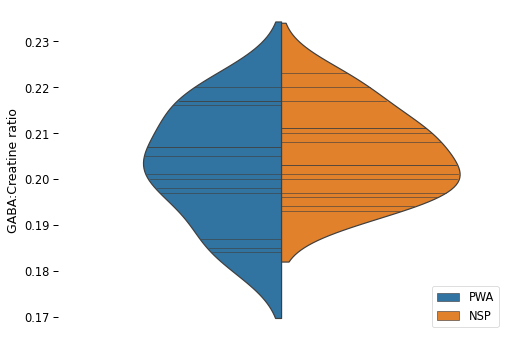

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [38]:
#with s.PdfPages(f"{plot_dir}/figure_04.pdf") as pdf:
#with sns.plotting_context(context=None, font_scale=1.3):
sns.set_context(context="paper", font_scale=1.3)
fig = plt.figure(figsize=(8,6))  # create a figure object
ax = fig.add_subplot(1, 1, 1)
ax = sns.violinplot(y='GABA',x='Presentation',hue='Population',data=gaba_df_immutable,split=True,inner='stick',ax=ax,legend=False, palette=colors2)
ax.legend(loc=4)
ax.xaxis.set_visible(False)
ax.set_ylabel('GABA:Creatine ratio')
sns.despine(left=True, bottom=True, right=True)
#ax.set_yticklabels([])
plt.show(ax.figure)
ax.figure.savefig(f"{plot_dir}/figure_04.eps", format="eps")
plt.close(ax.figure)
plt.close('all')

### Note: the subject with the lowest GABA:Cr ('tt', .162) is not in the psychophysics data

# Select one psychophysical task's data #

In [39]:
task = 'SS' # 'SS'
sdf = sdf[sdf['Task']==task]
df_to_model = sdf.copy(deep=True) # make a deep copy

In [40]:
df_to_model.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber
0,ai,SS,nMono,Iso,Nde,NSP,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2
1,ai,SS,nMono,Iso,Nde,NSP,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4
2,ai,SS,nMono,Iso,Nde,NSP,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6
3,ap,SS,nMono,Iso,Nde,NSP,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1
4,ap,SS,nMono,Iso,Nde,NSP,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2


In [41]:
n_pp_subjs_thistask = len(np.unique(df_to_model.Subject))
amb_subjs = np.unique(df_to_model[df_to_model["Population"]=="PWA"]["Subject"])
print(amb_subjs)
n_amb_subjs_thistask = len(amb_subjs)
print(f"There are {n_pp_subjs_thistask} subjects for Task {task}, of which {n_amb_subjs_thistask} are Amblyopes.")

['ah' 'am' 'bi' 'cl' 'eg' 'em' 'gd' 'jv' 'li' 'mg' 'mv' 'rn' 'sd']
There are 35 subjects for Task SS, of which 13 are Amblyopes.


### Verifying baselines based on KB feedback about fig R2

In [42]:
onecond = df_to_model[(df_to_model['Presentation']=='nMono') & (df_to_model['Orientation']=='Iso')]

In [43]:
cnde_subs = onecond[onecond['Trace']=='Control-Nde'].Subject.unique()

In [44]:
cde_subs = onecond[onecond['Trace']=='Control-De'].Subject.unique()

In [45]:
np.setdiff1d(cnde_subs, cde_subs)

array(['ap', 'bo', 'gw', 'ke', 'nn', 'tj'], dtype=object)

In [46]:
thresh_noswap = onecond.groupby(['Task','Orientation','Presentation','Population', 'Eye','Trace','Subject'], as_index=False)['BaselineThresh'].mean().dropna()

In [47]:
thresh_noswap.head()

,Task,Orientation,Presentation,Population,Eye,Trace,Subject,BaselineThresh
0,SS,Iso,nMono,PWA,De,Amblyope-De,ah,7.590
2,SS,Iso,nMono,PWA,De,Amblyope-De,am,7.532
4,SS,Iso,nMono,PWA,De,Amblyope-De,bi,7.827
6,SS,Iso,nMono,PWA,De,Amblyope-De,cl,6.709
10,SS,Iso,nMono,PWA,De,Amblyope-De,eg,6.826


In [48]:
eye_counts = thresh_noswap['Subject'].value_counts().reset_index()

In [49]:
eye_counts

,index,Subject
0,eg,2
1,li,2
2,nl,2
3,bi,2
4,yl,2
5,gd,2
6,gm,2
7,mv,2
8,cl,2
9,em,2


In [50]:
nounpaired = (eye_counts[eye_counts.Subject==2])['index'].unique()

In [51]:
nounpaired

array(['eg', 'li', 'nl', 'bi', 'yl', 'gd', 'gm', 'mv', 'cl', 'em', 'ms',
       'jd', 'cr', 'rn', 'mk', 'jv', 'ah', 'kw', 'ls', 'tm', 'dl', 'ct',
       'ei', 'ai', 'se', 'sd', 'es', 'am', 'mg'], dtype=object)

In [52]:
thresh_noswap_nounpaired = thresh_noswap[thresh_noswap['Subject'].isin(nounpaired)]

In [53]:
thresh_noswap.groupby(['Trace']).mean().reset_index()

,Trace,BaselineThresh
0,Amblyope-De,6.136462
1,Amblyope-Nde,7.318385
2,Control-De,6.309750
3,Control-Nde,5.894955


In [54]:
thresh_noswap_nounpaired.groupby(['Trace']).describe()

BaselineThresh                                              \
                      count      mean       std    min      25%     50%   
Trace                                                                     
Amblyope-De            13.0  6.136462  1.280663  4.063  5.94900  6.2620   
Amblyope-Nde           13.0  7.318385  2.364243  4.558  5.94400  6.7870   
Control-De             16.0  6.309750  1.559247  4.033  5.42650  6.0295   
Control-Nde            16.0  5.921750  1.467759  3.124  5.20325  5.6900   

                               
                  75%     max  
Trace                          
Amblyope-De   6.82600   7.827  
Amblyope-Nde  7.83400  13.226  
Control-De    6.90475   9.987  
Control-Nde   6.68325   8.794

In [55]:
#sns.swarmplot(data=onecond, x="Population", y="BaselineThresh", hue="Eye")

In [56]:
#sns.swarmplot(data=thresh_noswap_nounpaired, x="Population", y="BaselineThresh", hue="Eye")

### This is where the NDE/DE should be switched based on KB findings (only affects Controls, luckily)

But as the above plot shows, there are many more in Control-Nde than Control-De

In [57]:
def swap_eyevars(df, subs):
    #print(df, df['Subject'], len(df), sep='\n')
    if df['Subject'] in subs: # fix here
        print(df['Subject'], "SWAP!")
        if df['Eye'] == "De":
            df['Eye'] = "Nde"
            df['Trace'] = df['Trace'].replace('-De', '-Nde')
        else:
            df['Eye'] = "De"
            df['Trace'] = df['Trace'].replace('-Nde', '-De')
    return df

def fix_eyes(df):
    disp_cols = ['Subject','Eye','Trace','BaselineThresh']
    rows_to_change = df_to_model[df_to_model.Subject.isin(subs_to_swap_eyes)]
    assert(np.all(rows_to_change.Population == 'NSP')) # should only affect controls
    assert(np.all(rows_to_change.Trace.isin(['Control-De','Control-Nde']))) # these should be swapped along w/ Eye
    fixed = df.apply(swap_eyevars, subs=subs_to_swap_eyes, axis=1)
    print(fixed[disp_cols])
    return fixed

df_to_model_fixeyes = fix_eyes(df_to_model)

ai SWAP!
ai SWAP!
ai SWAP!
ct SWAP!
ct SWAP!
ct SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
ei SWAP!
ei SWAP!
ei SWAP!
kw SWAP!
kw SWAP!
kw SWAP!
nl SWAP!
nl SWAP!
nl SWAP!
ai SWAP!
ai SWAP!
ai SWAP!
ct SWAP!
ct SWAP!
ct SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
ei SWAP!
ei SWAP!
ei SWAP!
kw SWAP!
kw SWAP!
kw SWAP!
nl SWAP!
nl SWAP!
nl SWAP!
ai SWAP!
ai SWAP!
ai SWAP!
ct SWAP!
ct SWAP!
ct SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
ei SWAP!
ei SWAP!
ei SWAP!
kw SWAP!
kw SWAP!
kw SWAP!
nl SWAP!
nl SWAP!
nl SWAP!
ai SWAP!
ai SWAP!
ai SWAP!
ct SWAP!
ct SWAP!
ct SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
ei SWAP!
ei SWAP!
ei SWAP!
kw SWAP!
kw SWAP!
kw SWAP!
nl SWAP!
nl SWAP!
nl SWAP!
ai SWAP!
ai SWAP!
ai SWAP!
ct SWAP!
ct SWAP!
ct SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
ei SWAP!
ei SWAP!
ei SWAP!
kw SWAP!
kw SWAP!
kw SWAP!
nl SWAP!
nl SWAP!
nl SWAP!
ai SWAP!
ai SWAP!
ai SWAP!
ct SWAP!
ct SWAP!
ct SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
e

In [58]:
df_to_model_fixeyes.groupby("Trace")['BaselineThresh'].describe()

,count,mean,std,min,25%,50%,75%,max
Trace,,,,,,,,
Amblyope-De,208.0,6.170423,1.226235,4.063,5.949,6.262,6.826,7.827
Amblyope-Nde,204.0,7.228000,2.152685,4.558,5.944,6.787,7.834,13.226
Control-De,216.0,6.131833,1.435921,4.033,5.276,5.576,6.892,9.987
Control-Nde,342.0,5.981830,1.348685,3.124,5.006,5.741,6.745,8.957


### Toggle which version of the data to use, "fixed" eyes or not

In [59]:
df_to_model = df_to_model_fixeyes

# Preparation for Modeling

In [60]:
df_to_model.head() # note the first rows, they will tell if fixed - ai/Nde/6.9 -> ai/De/6.9 

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber
0,ai,SS,nMono,Iso,De,NSP,10.0,0.615,0.009,1.449,Control-De,6.900,1.552,2
1,ai,SS,nMono,Iso,De,NSP,30.0,0.671,0.010,4.348,Control-De,6.900,3.944,4
2,ai,SS,nMono,Iso,De,NSP,62.0,1.658,0.007,8.986,Control-De,6.900,11.345,6
3,ap,SS,nMono,Iso,Nde,NSP,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1
4,ap,SS,nMono,Iso,Nde,NSP,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2


### Begin grouping data into conditions to model Subject's ThreshElev as a function of MaskContrast

In [61]:
pp_gvars = ['Task','Orientation','Presentation','Population','Subject','Eye','Trace'] # One condition
pp_gvars_base = pp_gvars + ['BaselineThresh']

groups_with_baseline = df_to_model.groupby(pp_gvars_base)

# Check if there are any conditions with only two data points
for gv, gr in groups_with_baseline:
    if len(gr)<=2:
        print(gv, gr)

### BaselineThresh analysis before we exclude bad fits; since this is observed not modeled its ok

In [62]:
print(pp_gvars_base)
pp_gvars_base_agg = [v for v in pp_gvars if v != 'Subject']

['Task', 'Orientation', 'Presentation', 'Population', 'Subject', 'Eye', 'Trace', 'BaselineThresh']


In [63]:
pp_gvars_base_agg

['Task', 'Orientation', 'Presentation', 'Population', 'Eye', 'Trace']

In [64]:
for gv, g in df_to_model.groupby(pp_gvars_base_agg):
    print(gv, len(np.unique(g['BaselineThresh'])))

('SS', 'Cross', 'nDicho', 'NSP', 'De', 'Control-De') 16
('SS', 'Cross', 'nDicho', 'NSP', 'Nde', 'Control-Nde') 22
('SS', 'Cross', 'nDicho', 'PWA', 'De', 'Amblyope-De') 13
('SS', 'Cross', 'nDicho', 'PWA', 'Nde', 'Amblyope-Nde') 13
('SS', 'Cross', 'nMono', 'NSP', 'De', 'Control-De') 16
('SS', 'Cross', 'nMono', 'NSP', 'Nde', 'Control-Nde') 22
('SS', 'Cross', 'nMono', 'PWA', 'De', 'Amblyope-De') 13
('SS', 'Cross', 'nMono', 'PWA', 'Nde', 'Amblyope-Nde') 13
('SS', 'Iso', 'nDicho', 'NSP', 'De', 'Control-De') 16
('SS', 'Iso', 'nDicho', 'NSP', 'Nde', 'Control-Nde') 22
('SS', 'Iso', 'nDicho', 'PWA', 'De', 'Amblyope-De') 13
('SS', 'Iso', 'nDicho', 'PWA', 'Nde', 'Amblyope-Nde') 13
('SS', 'Iso', 'nMono', 'NSP', 'De', 'Control-De') 16
('SS', 'Iso', 'nMono', 'NSP', 'Nde', 'Control-Nde') 22
('SS', 'Iso', 'nMono', 'PWA', 'De', 'Amblyope-De') 13
('SS', 'Iso', 'nMono', 'PWA', 'Nde', 'Amblyope-Nde') 13


In [65]:
thresh_swap = df_to_model.groupby(['Task', 'Orientation', 'Presentation', 'Population', 'Subject','Eye', 'Trace'])['BaselineThresh'].mean().reset_index()
thresh_swap = thresh_swap[(thresh_swap.Orientation=="Iso")&(thresh_swap.Presentation=='nDicho')]
thresh_swap.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh
128,SS,Iso,nDicho,NSP,ai,De,Control-De,6.900
129,SS,Iso,nDicho,NSP,ai,Nde,Control-Nde,6.943
130,SS,Iso,nDicho,NSP,ap,Nde,Control-Nde,5.205
131,SS,Iso,nDicho,NSP,bo,Nde,Control-Nde,4.462
132,SS,Iso,nDicho,NSP,cr,De,Control-De,4.033


In [66]:
eye_counts_swap = thresh_swap.Subject.value_counts()
subs_no_unpaired = eye_counts[eye_counts_swap.reset_index()['Subject']==2]['index'].unique()
print(subs_no_unpaired, len(subs_no_unpaired))

['eg' 'li' 'nl' 'bi' 'yl' 'gd' 'gm' 'mv' 'cl' 'em' 'ms' 'jd' 'cr' 'rn'
 'mk' 'jv' 'ah' 'kw' 'ls' 'tm' 'dl' 'ct' 'ei' 'ai' 'se' 'sd' 'es' 'am'
 'mg'] 29


In [67]:
thresh_swap_nounpaired = thresh_swap[thresh_swap.Subject.isin(subs_no_unpaired)]

In [68]:
pd.Series.value_counts(thresh_swap_nounpaired.Subject)

cr    2
mv    2
gd    2
gm    2
jv    2
eg    2
nl    2
ms    2
bi    2
ah    2
mg    2
es    2
cl    2
em    2
jd    2
am    2
rn    2
li    2
yl    2
sd    2
ls    2
tm    2
dl    2
ct    2
ei    2
ai    2
se    2
mk    2
kw    2
Name: Subject, dtype: int64

In [69]:
thresh_swap_nounpaired.groupby(['Trace']).describe()

BaselineThresh                                             \
                      count      mean       std    min      25%    50%   
Trace                                                                    
Amblyope-De            13.0  6.136462  1.280663  4.063  5.94900  6.262   
Amblyope-Nde           13.0  7.318385  2.364243  4.558  5.94400  6.787   
Control-De             16.0  6.153313  1.557727  4.033  5.27500  5.564   
Control-Nde            16.0  6.078188  1.495439  3.124  5.25825  6.207   

                              
                 75%     max  
Trace                         
Amblyope-De   6.8260   7.827  
Amblyope-Nde  7.8340  13.226  
Control-De    6.8940   9.987  
Control-Nde   6.7945   8.957

#### Calculate differences, ratios etc for each subject

In [70]:
baseline_df_withinsubject = thresh_swap.groupby(#thresh_swap_nounpaired.groupby(
                                        ['Task', 'Orientation', 'Presentation', 'Population',
                                        'Subject']).apply(utils.get_interocular_diff, 'BaselineThresh')
baseline_df_withinsubject.rename(columns={'ValueDiff':'BaselineDiff', 'ValueRatio':'BaselineRatio'}, inplace=True)
baseline_df_withinsubject[(baseline_df_withinsubject.Population=="PWA") & (baseline_df_withinsubject.Eye=="De")]

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,BaselineDiff,BaselineRatio
166,SS,Iso,nDicho,PWA,ah,De,Amblyope-De,7.590,-3.032,0.600527
168,SS,Iso,nDicho,PWA,am,De,Amblyope-De,7.532,0.302,1.040096
170,SS,Iso,nDicho,PWA,bi,De,Amblyope-De,7.827,2.314,1.295643
172,SS,Iso,nDicho,PWA,cl,De,Amblyope-De,6.709,0.749,1.111641
174,SS,Iso,nDicho,PWA,eg,De,Amblyope-De,6.826,-0.039,0.994287
176,SS,Iso,nDicho,PWA,em,De,Amblyope-De,5.949,0.065,1.010926
178,SS,Iso,nDicho,PWA,gd,De,Amblyope-De,6.210,0.326,1.052496
180,SS,Iso,nDicho,PWA,jv,De,Amblyope-De,4.227,0.537,1.127040
182,SS,Iso,nDicho,PWA,li,De,Amblyope-De,4.063,3.253,1.800640
184,SS,Iso,nDicho,PWA,mg,De,Amblyope-De,4.174,1.480,1.354576


In [71]:
ade_threshs = baseline_df_withinsubject[(baseline_df_withinsubject.Population=="PWA") & (baseline_df_withinsubject.Eye=="De")]

In [72]:
baseline_df_withinsubject_diffs = baseline_df_withinsubject.groupby(['Population','Subject'], as_index=False)[['BaselineDiff','BaselineRatio']].mean()
baseline_df_withinsubject_diffs = categorize(baseline_df_withinsubject_diffs, 'Population', {'PWA':'PWA','NSP':'NSP'})
baseline_df_withinsubject_diffs

,Population,Subject,BaselineDiff,BaselineRatio
0,NSP,ai,0.043,1.006232
1,NSP,ap,NaN,NaN
2,NSP,bo,NaN,NaN
3,NSP,cr,-0.909,0.774609
4,NSP,ct,0.163,1.018535
5,NSP,dl,0.973,1.168572
6,NSP,ei,1.473,1.295486
7,NSP,es,0.130,1.023731
8,NSP,gm,-0.225,0.966063
9,NSP,gw,NaN,NaN


###  What if we exclude subject 'ah' who looks like a real outlier?

In [73]:
adiff = baseline_df_withinsubject_diffs[(baseline_df_withinsubject_diffs.Population=="PWA") &
                                        (baseline_df_withinsubject_diffs.Subject!="ah")].dropna()
cdiff = baseline_df_withinsubject_diffs[baseline_df_withinsubject_diffs.Population=="NSP"].dropna()

In [74]:
print("diffs: NDE-DE")
print(st.ttest_1samp(adiff['BaselineDiff'], popmean=0), len(adiff['BaselineDiff']))
print(st.ttest_1samp(cdiff['BaselineDiff'], popmean=0), len(cdiff['BaselineDiff']))
print(st.ttest_ind(adiff['BaselineDiff'], cdiff['BaselineDiff']))
print("\nratios: NDE/DE")
print(st.ttest_1samp(adiff['BaselineRatio'], popmean=1))
print(st.ttest_1samp(cdiff['BaselineRatio'], popmean=1))
print(st.ttest_ind(adiff['BaselineRatio'], cdiff['BaselineRatio']))

diffs: NDE-DE
Ttest_1sampResult(statistic=2.607249934573586, pvalue=0.02437678139493053) 12
Ttest_1sampResult(statistic=-0.39140781630414423, pvalue=0.700999760805944) 16
Ttest_indResult(statistic=2.909234602649429, pvalue=0.007327833537838826)

ratios: NDE/DE
Ttest_1sampResult(statistic=2.6759182869040505, pvalue=0.021564848189685324)
Ttest_1sampResult(statistic=-0.22134622628574366, pvalue=0.8278078450518245)
Ttest_indResult(statistic=2.918520108625673, pvalue=0.007166120691111577)


### Ok based on conversation with Michael, 'ah' is excluded now

In [75]:
baseline_df_withinsubject = baseline_df_withinsubject[baseline_df_withinsubject.Subject != 'ah']
baseline_df_withinsubject_diffs = baseline_df_withinsubject_diffs[baseline_df_withinsubject_diffs.Subject != 'ah']
df_to_model = df_to_model[df_to_model.Subject!='ah']

### GABA vs baseline contrast threshold, before excluding GABA-less people

In [76]:
baseline_gaba_plot_df = df_to_model.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])

In [77]:
simple_bg_df = baseline_gaba_plot_df.groupby(['Task','Orientation','Presentation','Population','Subject','Eye','Trace'])[['GABA','BaselineThresh']].agg(np.mean).reset_index()

In [78]:
simple_bg_df = simple_bg_df.rename(columns={"BaselineThresh":"value"})
simple_bg_df['measure'] = "BaselineThresh"
simple_bg_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,GABA,value,measure
0,SS,Cross,nDicho,NSP,ai,De,Control-De,0.223,6.900,BaselineThresh
1,SS,Cross,nDicho,NSP,ai,Nde,Control-Nde,0.223,6.943,BaselineThresh
2,SS,Cross,nDicho,NSP,ap,Nde,Control-Nde,NaN,5.205,BaselineThresh
3,SS,Cross,nDicho,NSP,bo,Nde,Control-Nde,NaN,4.462,BaselineThresh
4,SS,Cross,nDicho,NSP,cr,De,Control-De,0.201,4.033,BaselineThresh


In [79]:
len(simple_bg_df.Subject.unique())

34

In [80]:
simple_bg_df.Trace = simple_bg_df.Trace.astype('category')
simple_bg_df.Trace.cat.reorder_categories(traces4, inplace=True)
simple_bg_df.Trace.cat.rename_categories(traces_graph4, inplace=True)

In [81]:
simple_bg_df.groupby(['Task','Orientation','Presentation','Population', 'Eye', 'measure'])['value'].describe()

count      mean  \
Task Orientation Presentation Population Eye measure                           
SS   Cross       nDicho       NSP        De  BaselineThresh   16.0  6.153313   
                                         Nde BaselineThresh   22.0  6.008727   
                              PWA        De  BaselineThresh   12.0  6.015333   
                                         Nde BaselineThresh   12.0  7.548417   
                 nMono        NSP        De  BaselineThresh   16.0  6.153313   
                                         Nde BaselineThresh   22.0  6.008727   
                              PWA        De  BaselineThresh   12.0  6.015333   
                                         Nde BaselineThresh   12.0  7.548417   
     Iso         nDicho       NSP        De  BaselineThresh   16.0  6.153313   
                                         Nde BaselineThresh   22.0  6.008727   
                              PWA        De  BaselineThresh   12.0  6.015333   
                                         Nde BaselineThresh   12.0  7.548417   
                 nMono        NSP        De  BaselineThresh   16.0  6.153313   
                                         Nde BaselineThresh   22.0  6.008727   
                              PWA        De  BaselineThresh   12.0  6.015333   
                                         Nde BaselineThresh   12.0  7.548417   

                                                                  std    min  \
Task Orientation Presentation Population Eye measure                           
SS   Cross       nDicho       NSP        De  BaselineThresh  1.557727  4.033   
                                         Nde BaselineThresh  1.452858  3.124   
                              PWA        De  BaselineThresh  1.257427  4.063   
                                         Nde BaselineThresh  2.312438  4.764   
                 nMono        NSP        De  BaselineThresh  1.557727  4.033   
                                         Nde BaselineThresh  1.452858  3.124   
                              PWA        De  BaselineThresh  1.257427  4.063   
                                         Nde BaselineThresh  2.312438  4.764   
     Iso         nDicho       NSP        De  BaselineThresh  1.557727  4.033   
                                         Nde BaselineThresh  1.452858  3.124   
                              PWA        De  BaselineThresh  1.257427  4.063   
                                         Nde BaselineThresh  2.312438  4.764   
                 nMono        NSP        De  BaselineThresh  1.557727  4.033   
                                         Nde BaselineThresh  1.452858  3.124   
                              PWA        De  BaselineThresh  1.257427  4.063   
                                         Nde BaselineThresh  2.312438  4.764   

                                                                 25%     50%  \
Task Orientation Presentation Population Eye measure                           
SS   Cross       nDicho       NSP        De  BaselineThresh  5.27500  5.5640   
                                         Nde BaselineThresh  5.05575  5.8465   
                              PWA        De  BaselineThresh  5.51850  6.2360   
                                         Nde BaselineThresh  5.99650  7.0515   
                 nMono        NSP        De  BaselineThresh  5.27500  5.5640   
                                         Nde BaselineThresh  5.05575  5.8465   
                              PWA        De  BaselineThresh  5.51850  6.2360   
                                         Nde BaselineThresh  5.99650  7.0515   
     Iso         nDicho       NSP        De  BaselineThresh  5.27500  5.5640   
                                         Nde BaselineThresh  5.05575  5.8465   
                              PWA        De  BaselineThresh  5.51850  6.2360   
                                         Nde BaselineThresh  5.99650  7.0515   
                 nMono        NSP        De  BaselineThresh

In [82]:
simple_bg_df_nonan = simple_bg_df[~np.isnan(simple_bg_df.GABA)]

In [83]:
simple_bg_df_nonan_onecond = (simple_bg_df_nonan[(simple_bg_df_nonan['Presentation']=='nDicho') & (simple_bg_df_nonan['Orientation']=='Iso')])

In [84]:
len(simple_bg_df_nonan_onecond.Subject.unique())

22

In [85]:
simple_bg_df_nonan_onecond

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,GABA,value,measure
124,SS,Iso,nDicho,NSP,ai,De,"Normally-sighted\npersons, DE",0.223,6.900,BaselineThresh
125,SS,Iso,nDicho,NSP,ai,Nde,"Normally-sighted\npersons, NDE",0.223,6.943,BaselineThresh
128,SS,Iso,nDicho,NSP,cr,De,"Normally-sighted\npersons, DE",0.201,4.033,BaselineThresh
129,SS,Iso,nDicho,NSP,cr,Nde,"Normally-sighted\npersons, NDE",0.201,3.124,BaselineThresh
130,SS,Iso,nDicho,NSP,ct,De,"Normally-sighted\npersons, DE",0.208,8.794,BaselineThresh
131,SS,Iso,nDicho,NSP,ct,Nde,"Normally-sighted\npersons, NDE",0.208,8.957,BaselineThresh
132,SS,Iso,nDicho,NSP,dl,De,"Normally-sighted\npersons, DE",0.220,5.772,BaselineThresh
133,SS,Iso,nDicho,NSP,dl,Nde,"Normally-sighted\npersons, NDE",0.220,6.745,BaselineThresh
134,SS,Iso,nDicho,NSP,ei,De,"Normally-sighted\npersons, DE",0.200,4.985,BaselineThresh
135,SS,Iso,nDicho,NSP,ei,Nde,"Normally-sighted\npersons, NDE",0.200,6.458,BaselineThresh


In [86]:
# check swapped eyes subs
simple_bg_df_nonan_onecond

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,GABA,value,measure
124,SS,Iso,nDicho,NSP,ai,De,"Normally-sighted\npersons, DE",0.223,6.900,BaselineThresh
125,SS,Iso,nDicho,NSP,ai,Nde,"Normally-sighted\npersons, NDE",0.223,6.943,BaselineThresh
128,SS,Iso,nDicho,NSP,cr,De,"Normally-sighted\npersons, DE",0.201,4.033,BaselineThresh
129,SS,Iso,nDicho,NSP,cr,Nde,"Normally-sighted\npersons, NDE",0.201,3.124,BaselineThresh
130,SS,Iso,nDicho,NSP,ct,De,"Normally-sighted\npersons, DE",0.208,8.794,BaselineThresh
131,SS,Iso,nDicho,NSP,ct,Nde,"Normally-sighted\npersons, NDE",0.208,8.957,BaselineThresh
132,SS,Iso,nDicho,NSP,dl,De,"Normally-sighted\npersons, DE",0.220,5.772,BaselineThresh
133,SS,Iso,nDicho,NSP,dl,Nde,"Normally-sighted\npersons, NDE",0.220,6.745,BaselineThresh
134,SS,Iso,nDicho,NSP,ei,De,"Normally-sighted\npersons, DE",0.200,4.985,BaselineThresh
135,SS,Iso,nDicho,NSP,ei,Nde,"Normally-sighted\npersons, NDE",0.200,6.458,BaselineThresh


### Figure 7

In [87]:
bg_groups = simple_bg_df_nonan.groupby(['Task','Orientation','Presentation','measure'])
#with s.PdfPages(f"{plot_dir}/figure_07.pdf") as pdf:
i = 0 # only do the first group since they're all the same
for gv, gr in bg_groups:
    if i==0:
        g = s.gaba_vs_psychophys_plot(gv, gr, legend=False,
                    log=True, ylim=(2.5, 16), truncate=False,
                    col="Population", col_order=["PWA", "NSP"], hue="Trace",
                    sharex=False, sharey=False,
                    palette=pal4g,
                    n_boot=n_boot, legend_img=False,
                    markers=['o','^','o','^'],
                    aspect=1)
        #g.fig.suptitle(f"{gv}", fontsize=10, y=0.999)
        g.set_titles("")
        #g.fig.subplots_adjust(left=.08, wspace=.2, right=.99)
        g.fig.savefig(f"{plot_dir}/figure_07.pdf")
        plt.close('all')
        i = 1

('SS', 'Cross', 'nDicho', 'BaselineThresh')
nDicho

Percentiles for individual eye correlations:
Amb DE 
Observed value of -0.405 is greater than 0.152 of bootstrap distribution, corresponding to p=0.30.
Amb NDE 
Observed value of -0.214 is greater than 0.302 of bootstrap distribution, corresponding to p=0.60.
Con DE 
Observed value of 0.174 is greater than 0.756 of bootstrap distribution, corresponding to p=0.49.
Con NDE 
Observed value of 0.196 is greater than 0.760 of bootstrap distribution, corresponding to p=0.48.

Percentiles for permuted r_s differences:
Amb NDE vs DE 
Observed value of 0.190 is greater than 0.644 of bootstrap distribution, corresponding to p=0.71.
Con NDE vs DE 
Observed value of 0.022 is greater than 0.508 of bootstrap distribution, corresponding to p=0.98.
Pop Amb vs Con 
Observed value of 0.168 is greater than 0.614 of bootstrap distribution, corresponding to p=0.77.
[0.304 0.604 0.488 0.48 ], [0.712 0.984 0.772]



#### Figure 6 combined into one panel

In [88]:
baseline_df_withinsubject_diffs

,Population,Subject,BaselineDiff,BaselineRatio
0,NSP,ai,0.043,1.006232
1,NSP,ap,NaN,NaN
2,NSP,bo,NaN,NaN
3,NSP,cr,-0.909,0.774609
4,NSP,ct,0.163,1.018535
5,NSP,dl,0.973,1.168572
6,NSP,ei,1.473,1.295486
7,NSP,es,0.130,1.023731
8,NSP,gm,-0.225,0.966063
9,NSP,gw,NaN,NaN


In [89]:
baseline_df_withinsubject.Trace = baseline_df_withinsubject.Trace.astype('category')
baseline_df_withinsubject.Trace.cat.reorder_categories(traces4, inplace=True)
baseline_df_withinsubject.Trace.cat.rename_categories(traces_graph4, inplace=True)

In [90]:
baseline_df_withinsubject.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,BaselineDiff,BaselineRatio
128,SS,Iso,nDicho,NSP,ai,De,"Normally-sighted\npersons, DE",6.900,0.043,1.006232
129,SS,Iso,nDicho,NSP,ai,Nde,"Normally-sighted\npersons, NDE",6.943,0.043,1.006232
130,SS,Iso,nDicho,NSP,ap,Nde,"Normally-sighted\npersons, NDE",5.205,NaN,NaN
131,SS,Iso,nDicho,NSP,bo,Nde,"Normally-sighted\npersons, NDE",4.462,NaN,NaN
132,SS,Iso,nDicho,NSP,cr,De,"Normally-sighted\npersons, DE",4.033,-0.909,0.774609


Population
NSP    22
PWA    12
Name: Subject, dtype: int64
Population
PWA    12
NSP    22
Name: Subject, dtype: int64


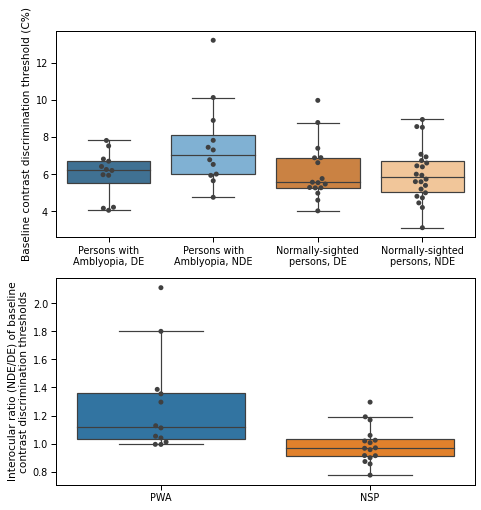

In [91]:
#with s.PdfPages(f"{plot_dir}/figure_06.pdf") as pdf:
sns.set_context(context="paper", font_scale=1.1)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))#, gridspec_kw={"width_ratios":[2, 1]})
g = sns.boxplot(data=baseline_df_withinsubject,
                x='Trace',
                y='BaselineThresh',#value',
                ax=ax[0],
                palette=pal4g, fliersize=0)
g = sns.swarmplot(data=baseline_df_withinsubject,
                  x='Trace',
                  y='BaselineThresh',
                  ax=ax[0], color=".25")
g.set_xlabel('')
g.set_ylabel('Baseline contrast discrimination threshold (C%)')
print(baseline_df_withinsubject.groupby(['Population'])['Subject'].nunique())


g2 = sns.boxplot(data=baseline_df_withinsubject_diffs,
                 x='Population',
                 #y='BaselineDiff',
                 y='BaselineRatio',
                 ax=ax[1],
                 fliersize=0, palette=colors2)
g2 = sns.swarmplot(data=baseline_df_withinsubject_diffs,
                   x='Population',
                   #y='BaselineDiff',
                   y='BaselineRatio',
                   ax=ax[1],
                   color=".25")
#g2.legend().remove()
g2.set_xlabel('')
#g2.set_ylabel('Interocular difference (NDE-DE) in baseline\ncontrast discrimination thresholds (C%)')
g2.set_ylabel('Interocular ratio (NDE/DE) of baseline\ncontrast discrimination thresholds')
plt.subplots_adjust(left=.12, right=.95, top=.95, bottom=.05, hspace=.2)
print(baseline_df_withinsubject_diffs.groupby(['Population'])['Subject'].nunique())

fig.savefig(f"{plot_dir}/figure_06.eps")
plt.show()
plt.close('all')

In [92]:
baseline_df_withinsubject.groupby(['Population','Eye']).describe()

BaselineThresh                                              \
                        count      mean       std    min      25%     50%   
Population Eye                                                              
NSP        De            16.0  6.153313  1.557727  4.033  5.27500  5.5640   
           Nde           22.0  6.008727  1.452858  3.124  5.05575  5.8465   
PWA        De            12.0  6.015333  1.257427  4.063  5.51850  6.2360   
           Nde           12.0  7.548417  2.312438  4.764  5.99650  7.0515   

                                BaselineDiff            ...                  \
                    75%     max        count      mean  ...      75%    max   
Population Eye                                          ...                   
NSP        De   6.89400   9.987         16.0 -0.075125  ...  0.19950  1.473   
           Nde  6.71150   8.957         16.0 -0.075125  ...  0.19950  1.473   
PWA        De   6.73825   7.827         12.0  1.533083  ...  2.35625  6.964   
           Nde  8.10225  13.226         12.0  1.533083  ...  2.35625  6.964   

               BaselineRatio                                          \
                       count      mean       std       min       25%   
Population Eye                                                         
NSP        De           16.0  0.992533  0.134933  0.774609  0.909571   
           Nde          16.0  0.992533  0.134933  0.774609  0.909571   
PWA        De           12.0  1.273315  0.353819  0.993814  1.032803   
           Nde          12.0  1.273315  0.353819  0.993814  1.032803   

                                              
                     50%       75%       max  
Population Eye                                
NSP        De   0.967698  1.032396  1.295486  
           Nde  0.967698  1.032396  1.295486  
PWA        De   1.119341  1.362562  2.112105  
           Nde  1.119341  1.362562  2.112105  

[4 rows x 24 columns]

## Plot and model the suppression data (RelMaskContrast vs ThreshElev)

In [93]:
df_to_model.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber
0,ai,SS,nMono,Iso,De,NSP,10.0,0.615,0.009,1.449,Control-De,6.900,1.552,2
1,ai,SS,nMono,Iso,De,NSP,30.0,0.671,0.010,4.348,Control-De,6.900,3.944,4
2,ai,SS,nMono,Iso,De,NSP,62.0,1.658,0.007,8.986,Control-De,6.900,11.345,6
3,ap,SS,nMono,Iso,Nde,NSP,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1
4,ap,SS,nMono,Iso,Nde,NSP,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2


In [94]:
np.unique(df_to_model.MaskContrast)

array([ 5., 10., 17., 18., 30., 32., 39., 45., 50., 56., 60., 62., 74.,
       79., 99.])

In [95]:
# #bins = [0, 6, 11, 19, 33, 51, 63, 80, 100] # 17/18, 30/32, 39/45/50, 56/60/62, 74/79, and 99%
# bins = [0, 6, 11, 19, 33, 63, 80, 100] # 17/18, 30/32, 39/45/50/56/60/62, 74/79, and 99%
# #bins = [0, 6, 11, 19, 33, 63, 100]# 17/18, 30/32, 39/45/50/56/60/62, 74/79/99%
# df_to_model['Bin2'] = pd.cut(df_to_model['MaskContrast'], bins=bins, labels=[x+1 for x in range(len(bins)-1)])

In [96]:
np.unique(df_to_model.RelMaskContrast)

array([ 0.561,  0.67 ,  0.683,  0.741,  0.745,  0.765,  0.778,  0.805,
        0.831,  0.84 ,  0.841,  0.866,  0.871,  0.892,  0.913,  0.961,
        0.986,  1.001,  1.085,  1.116,  1.121,  1.123,  1.137,  1.166,
        1.172,  1.187,  1.231,  1.276,  1.278,  1.328,  1.341,  1.35 ,
        1.361,  1.367,  1.412,  1.44 ,  1.449,  1.451,  1.465,  1.473,
        1.483,  1.491,  1.508,  1.513,  1.53 ,  1.548,  1.557,  1.561,
        1.61 ,  1.663,  1.664,  1.672,  1.68 ,  1.681,  1.682,  1.732,
        1.742,  1.769,  1.783,  1.785,  1.793,  1.801,  1.825,  1.85 ,
        1.89 ,  1.896,  1.897,  1.921,  1.998,  2.006,  2.021,  2.076,
        2.099,  2.111,  2.241,  2.298,  2.39 ,  2.396,  2.413,  2.419,
        2.46 ,  2.461,  2.479,  2.637,  2.652,  2.669,  2.683,  2.715,
        2.754,  2.802,  2.811,  2.827,  2.858,  2.874,  2.899,  2.958,
        3.004,  3.024,  3.118,  3.136,  3.201,  3.21 ,  3.286,  3.349,
        3.402,  3.411,  3.458,  3.515,  3.596,  3.732,  3.833,  4.034,
      

In [97]:
sns.relplot(data=df_to_model, x="MaskContrast", y="ThreshElev", hue="Trace",
                        row="Orientation",
                        #col="Population", col_order=["PWA", "NSP"],
                        col="Presentation", col_order=["nMono", "nDicho"],
                        palette=pal4, style="Eye", markers=['o','d'],
                        height=4.5, aspect=1.3)\
    .map(plt.axhline, y=1, linestyle='dotted', color='black')\
    .set(ylabel="Threshold Elevation")\
    .set(xlabel='Surround Contrast (C%)')
plt.close('all')

In [98]:
sns.relplot(data=df_to_model, x="RelMaskContrast", y="ThreshElev", hue="Trace",
                        row="Orientation",
                        #col="Population", col_order=["PWA", "NSP"],
                        col="Presentation", col_order=["nMono", "nDicho"],
                        palette=pal4, style="Eye", markers=['o','d'],
                        height=4.5, aspect=1.3)\
.map(plt.axhline, y=1, linestyle='dotted', color='black')\
.map(plt.axvline, x=2, linestyle='dotted', color='grey')\
.map(plt.axvline, x=5, linestyle='dotted', color='grey')\
.map(plt.axvline, x=10, linestyle='dotted', color='grey')\
.set(ylabel="Threshold Elevation")\
.set(xlabel='Relative surround contrast\n (multiples of baseline)')
plt.close('all')

## Pick critical value and observations closest to that
#### Everything after this must be repeated for different critical values to show robustness

In [99]:
def closest_obs(df, col, to):
    co = (df.iloc[np.argmin(np.abs(df[col] - to))])
    #print(co, co.name, co.index, sep='\n')
    return co

def annotate(data, field="hue", pos=(.05, .7), **kws):
    #print(field, data[['Eye',field]], kws)
    ax=plt.gca()
    for (i, (gv, g)) in enumerate(data.groupby(field)):
        print(i, gv)
        pos_this=(pos[0], pos[1]+(.05*i))
        annotation = f"{gv} n={len(g)}"
        ax.text(*pos_this, annotation, transform=ax.transAxes)
        


In [ ]:
cv = 5
print(f"**Analysis at RelMaskContrast={cv}**\n")
final_obs = df_to_model.groupby(pp_gvars).apply(closest_obs, 'RelMaskContrast', cv).reset_index(drop=True)
sub_groups = final_obs.groupby(['Task','Orientation','Presentation','Population','Subject'], as_index=False)
xdiffs = sub_groups.apply(utils.get_interocular_diff, "RelMaskContrast").dropna().drop_duplicates(['Task','Orientation','Presentation','Subject','ValueDiff'])

#print(xdiffs)
#     sns.catplot(kind='bar', data=xmeans, x='Trace', y='RelMaskContrast', order=traces4, row="Orientation", col="Presentation", palette=pal4)\
#         .set(ylabel='Mean of relative surround contrasts tested')
g1 = sns.catplot(kind='box', data=xdiffs, x='Population', y='ValueDiff', order=["PWA", "NSP"],
            row="Orientation", row_order=["Iso", "Cross"],
            col="Presentation", col_order=["nMono", "nDicho"],
            height=4, aspect=1.1,
            palette=colors2)\
    .map_dataframe(annotate, field='Population', pos=(.7, .1))\
    .set(ylabel=f"Interocular difference (Nde-De) of tested\nrelative surround contrasts at cv={cv}")
g1.fig.subplots_adjust(wspace=.2, hspace=.2)
plt.show()
sns.relplot(data=final_obs, x="RelMaskContrast", y="ThreshElev", hue="Trace",
            row="Orientation", row_order=["Iso", "Cross"],
            col="Presentation", col_order=["nMono", "nDicho"],
            palette=pal4, style="Eye", markers=['o','d'],
            height=4.5, aspect=1.2)\
.map_dataframe(annotate)\
.map(plt.axhline, y=1, linestyle='dotted', color='black')\
.map(plt.axvline, x=cv, linestyle='dotted', color='grey')\
.set(ylabel=f"Threshold Elevation\nat cv={cv}")\
.set(xlabel='Relative surround contrast\n (multiples of baseline)')
plt.show()
plt.close('all')

**Analysis at RelMaskContrast=5**



In [ ]:
final_obs.groupby(['Task','Orientation','Presentation','Population','Eye'])[['RelMaskContrast','ThreshElev']].describe(percentiles=[.5])

In [ ]:
#apply this to final_obs to get t-tests

def test_eye_diffs(g, col):
    ndes = np.unique(g[g.Eye=='Nde'][col])
    des = np.unique(g[g.Eye=='De'][col])
    #g.hist()
    #print("nde mean: ", np.mean(ndes), "de mean: ", np.mean(des))
    res = st.ttest_ind(ndes, des)
    #display(HTML(g.to_html()))
    print(f"({len(ndes)}, {len(des)}), t={res.statistic:.2f}, p={res.pvalue:.2f}")
    return st.ttest_ind(ndes, des)

gs = final_obs.groupby(['Task','Orientation','Presentation','Population'])
for gv, g in gs:
    print(gv)
    test_eye_diffs(g, "ThreshElev")

### Make Figure 3, the modeling example

In [ ]:
onecond = df_to_model[(df_to_model.Orientation=="Iso") & (df_to_model.Presentation=="nDicho")]
ns_onecond = onecond.groupby(['Task','Orientation','Presentation','Population','Eye','Trace'])['Subject'].nunique().reset_index()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 8), dpi=300)

sns.scatterplot(data=onecond, ax=ax1, x="MaskContrast", y="ThreshElev", hue="Trace",
                        palette=pal4, legend=False)
ax1.set(ylabel="Relative contrast\ndiscrimination threshold")
ax1.set(xlabel='Surround Contrast')
ax1.axhline(y=1, linestyle='dotted', color='grey')

sns.scatterplot(data=onecond, ax=ax2, x="RelMaskContrast", y="ThreshElev", hue="Trace",
                        palette=pal4, legend=False)
ax2.set(ylabel="Relative contrast\ndiscrimination threshold")
ax2.set(xlabel='Relative surround contrast\n (multiples of baseline)')
ax2.axhline(y=1, linestyle='dotted', color='grey')
ax2.axvline(x=5, linestyle='dotted', color='black')
print()

final_obs_onecond = onecond.groupby(pp_gvars).apply(closest_obs, 'RelMaskContrast', cv).reset_index(drop=True)

sns.scatterplot(data=final_obs_onecond, ax=ax3, x="RelMaskContrast", y="ThreshElev", hue="Trace",
                        palette=pal4, legend="brief")
ax3.legend_.set_visible(False)
ax3.set(xlim=ax2.get_xlim())
ax3.set(ylabel="Relative contrast\ndiscrimination threshold")
ax3.set(xlabel='Relative surround contrast\n (multiples of baseline)')
ax3.axhline(y=1, linestyle='dotted', color='grey')
ax3.axvline(x=5, linestyle='dotted', color='black')
handles, labels = ax3.get_legend_handles_labels()
h_leg = []
l_leg = []
for (h, l) in zip(handles, labels):
    if l in traces4:
        i = traces4.index(l)
        n = ns_onecond[ns_onecond.Trace==l]['Subject'].iloc[0]
        print(h, l, i, n, traces_graph4[i])
        h_leg.append(h)
        l_leg.append(f"{traces_graph4[i]}\n(N={n})")

fig.legend(h_leg, l_leg, loc='center right')
#fig.legend(pal4g)
fig.subplots_adjust(hspace=.5, right=.7)
plt.savefig(f"{plot_dir}/figure_03.eps")
plt.close('all')

## Subset to include only (GABA and psychophyics) subjects

In [ ]:
gaba_and_pp_subjs = list(np.intersect1d(pp_subjs, gaba_subjs))
n_gaba_and_pp_subjs = len(gaba_and_pp_subjs)

In [ ]:
sdf = sdf[sdf.Subject.isin(gaba_and_pp_subjs)] # only subjects who did _the current_ pp task and GABA
gaba_and_pp_subjs_thistask = np.unique(sdf.Subject)
n_gaba_and_pp_subjs_thistask = len(gaba_and_pp_subjs_thistask)
print(f"Of the {n_gaba_and_pp_subjs} subjects with both GABA and psychophysics data, {n_gaba_and_pp_subjs_thistask} have both for task {task}.\n{gaba_and_pp_subjs_thistask}")

### Remove subjects we don't have data on both GABA/PP for

In [ ]:
gdf = gdf[gdf.subjName.isin(sdf.Subject)] # only subjects who did both tasks
amb_subjs = (gdf[gdf.Population=='PWA'])
nsp_subjs = (gdf[gdf.Population=="NSP"])
print(f'Of the {len(gdf)} subjects with GABA and {task} data, {len(amb_subjs)} are PWA.')
n_this_task = len(gdf)

In [ ]:
final_obs.head()

In [ ]:
comb = final_obs.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])
comb.drop_duplicates(inplace=True)

#subset to include only those subjects with GABA data
comb_gabappsub = comb[~np.isnan(comb['GABA'])]
print(len(comb), len(comb_gabappsub))
comb_gabappsub.Subject.unique()

In [ ]:
comb.head()

In [ ]:
print(pp_gvars)

In [ ]:
baz = pd.melt(comb, id_vars=(pp_gvars + ['RelMaskContrast','BaselineThresh','GABA']),
              value_vars=["ThreshElev"], var_name='measure')
baz.dropna(subset=['GABA'], inplace=True)
baz.Trace = baz.Trace.astype('category')
baz_temp = baz.Trace.copy()
baz.Trace.cat.reorder_categories(traces4, inplace=True)
assert(baz_temp.equals(baz.Trace))
baz.Trace.cat.rename_categories(traces_graph4, inplace=True)

In [ ]:
pal4g

#### Figures 8 and 9 and produced here

In [ ]:
%%time
fig_groups = baz.groupby(['Task', 'Orientation', 'measure'])
for fgv, fg in fig_groups:
    #print(fg)
    assert(fg['Orientation'].nunique()==1) # we're only looking at one surround orientation per figure
    o = fg['Orientation'].iloc[0] # first element can be used for all
    if o=="Cross":
        # figure 8
        outfile = f"{plot_dir}/figure_08.pdf"
        ylim = (0.2,4)
    elif o=="Iso":
        # figure 9
        outfile = f"{plot_dir}/figure_09.pdf"
        ylim = (0.2, 6)
    else:
        # problem
        raise Error
    g = s.gaba_vs_psychophys_plot(fgv, fg, 
                legend_img = False,
                legend = False,
                log = True,
                sharex=False, sharey=False,
                truncate=False,
                ylim = ylim,
                row="Presentation", row_order=["nDicho", "nMono"],
                col="Population", col_order=["PWA","NSP"],
                hue="Trace",
                palette=pal4g,
                annotate=True, boot_func=utils.compare_rs, 
                n_boot=n_boot,
                markers=['o','d','o','d'])#, legend=False)
    g.set_titles("") # top row is dichoptic
    print(g.fig.get_size_inches(), g.fig.get_dpi())
    g.fig.subplots_adjust(left=.1, right=.95, wspace=0.15)
    g.fig.set_dpi(300)
    g.fig.set_size_inches((7,7))
    g.fig.savefig(outfile, dpi='figure')
    plt.close('all')

# Orientation-selective surround suppression analysis
 * 6/7/21 post MAS: made this analysis refer to final_obs, not baz, thus including psychophys subjects we don't have GABA for and necessatitating the removal of GABA - OSSS results

In [ ]:
final_obs.head()

In [ ]:
oss_gvars = ["Task", "Presentation", "Population", "Subject", "Eye", "Trace"]#, "GABA"]
oss_gvars_combeyes = ["Task", "Presentation", "Population", "Subject", "Trace"]#, "GABA"]
#oss_df = baz.groupby(oss_gvars).apply(utils.calculate_orientation_selective_suppression).reset_index().dropna()
oss_df = final_obs.groupby(oss_gvars).apply(utils.calculate_orientation_selective_suppression, col='ThreshElev').reset_index().dropna()
oss_df['measure'] = 'OSSSRatio'

In [ ]:
oss_df.head(n=5)

In [ ]:
oss_df.groupby(['Task', 'Presentation', 'Population','Eye'])['value'].agg(['mean', 'sem'])

In [ ]:
for gv, g in oss_df.groupby(['Task', 'Presentation', 'Population','Eye']):
    print(gv)#, g, sep='\n')
    ttres = st.ttest_1samp(g['value'], popmean=1, nan_policy='omit')
    print(f"N = {len(g)}, mean Iso/Cross ratio: {g['value'].mean():.2f}, t={ttres.statistic:.2f}, p={ttres.pvalue}")
    #print(st.spearmanr(g['GABA'], g['value']))

In [ ]:
# # combine both eyes (omit 'Eye' from grouping vars)
# def oss_mean_combeyes(df, **kwargs):
#     if len(df.Eye.unique())==2:
#         v1 = df[df.Eye=='Nde']['value'].iloc[0]
#         v2 = df[df.Eye=='De']['value'].iloc[0]
#         oss_mean_combeyes = np.mean([v1, v2])
#     elif len(df.Eye.unique())==1:
#         oss_mean_combeyes = df.value.iat[0]
#     else:
#         oss_mean_combeyes = np.nan
#     #print(df)
#     print(f"OSS mean across eyes: {oss_mean_combeyes}")
#     return pd.Series(oss_mean_combeyes, ['value'])
# oss_df_combeyes = oss_df.groupby(oss_gvars_combeyes).apply(oss_mean_combeyes).reset_index().dropna()
# for gv, g in oss_df_combeyes.groupby(['Task', 'Presentation', 'Population']):
#     print(gv, len(np.unique(g['Subject'])), np.unique(g['Subject']))#, g, sep='\n')
#     print(np.mean(g['value']), np.std(g['value']))
#     print(st.ttest_1samp(g['value'], popmean=1, nan_policy='omit'))
#     print(st.spearmanr(g['GABA'], g['value']))

In [ ]:
# for gv, g in oss_df_combeyes.groupby(['Task', 'Presentation']):
#     print(gv, len(np.unique(g['Subject'])), np.unique(g['Subject']))#, g, sep='\n')
#     pwa = g[g.Population=='PWA']
#     nsp = g[g.Population=='NSP']
#     print('NSP: ', st.ttest_1samp(nsp['value'], popmean=1, nan_policy='omit'), 'PWA: ', st.ttest_1samp(pwa['value'], popmean=1, nan_policy='omit'), sep='\n')
#     print('NSP vs PWA 2-samp: ', st.ttest_ind(nsp['value'], pwa['value']))
#     for gv2, g2 in g.groupby(['Population']):
#         print(st.spearmanr(g2['GABA'], g2['value']))